In [53]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
from rasterio.plot import show
import pyproj
%matplotlib inline
import os

In [20]:
#Red
band4 = rasterio.open('Landsat8/LC09_L2SP_192027_20220703_20220705_02_T1_SR_B4.TIF')
#NIR
band5= rasterio.open('Landsat8/LC09_L2SP_192027_20220703_20220705_02_T1_SR_B5.TIF')

In [21]:
print(band4.height)
print(band4.width)

8081
8001


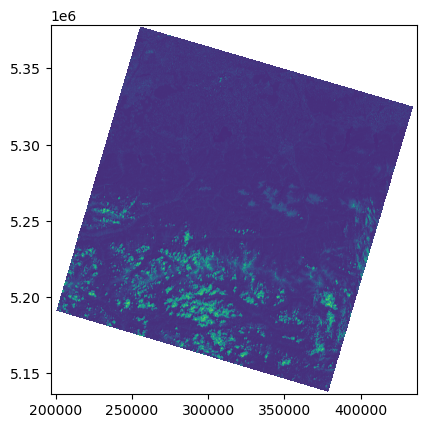

<AxesSubplot:>

In [22]:
plot.show(band4)

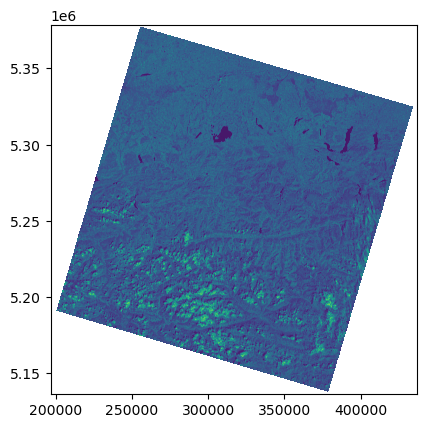

<AxesSubplot:>

In [23]:
plot.show(band5)

In [24]:
#type of raster byte
band4.dtypes[0]

'uint16'

In [25]:
#raster sytem of reference
band4.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [26]:
#raster transform parameters
band4.transform

Affine(30.0, 0.0, 196785.0,
       0.0, -30.0, 5378715.0)

In [27]:
#raster values as matrix array
band4.read(1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

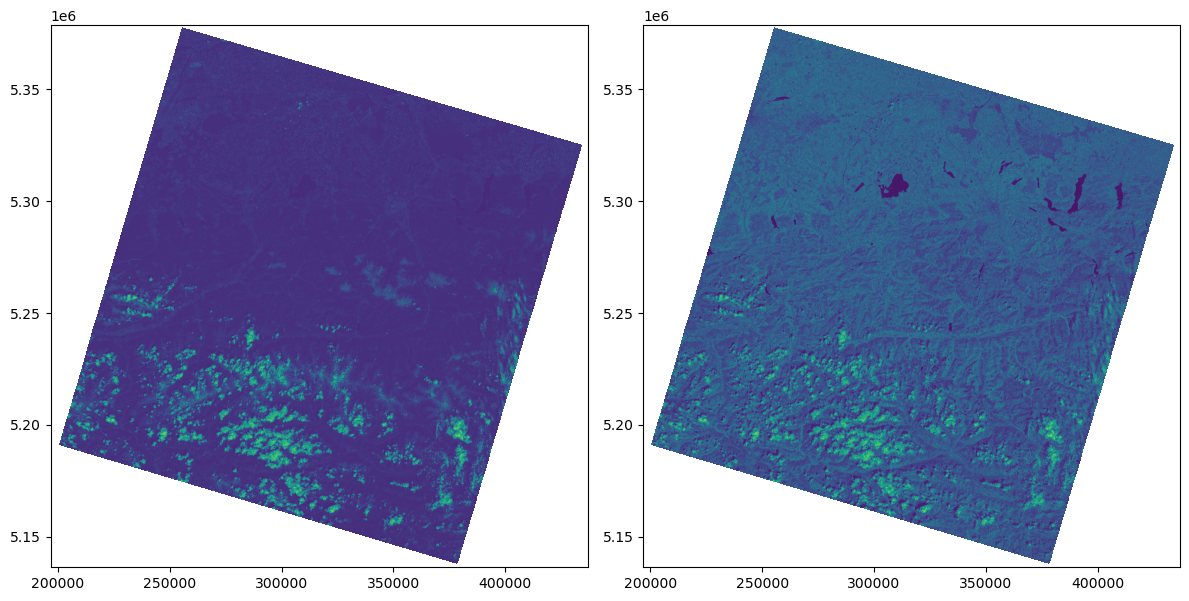

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot.show(band4, ax=ax1, cmap='viridis') #red
plot.show(band5, ax=ax2, cmap='viridis') #nir
fig.tight_layout()

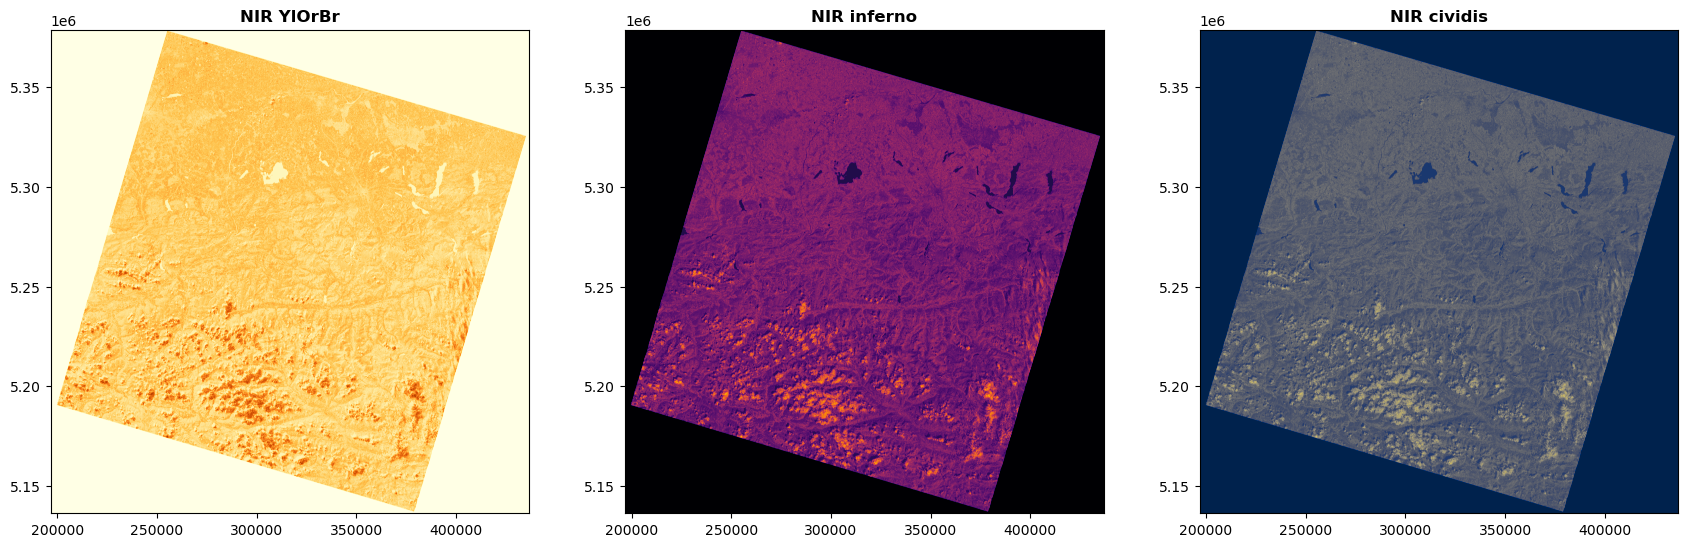

In [29]:
fig, (axr, axg, axb) = pyplot.subplots(1,3, figsize=(21,7))
show((band5, 1), ax=axr, cmap='YlOrBr', title='NIR YlOrBr')
show((band5, 1), ax=axg, cmap='inferno', title='NIR inferno')
show((band5, 1), ax=axb, cmap='cividis', title='NIR cividis')
pyplot.show()

In [30]:
#generate nir and red objects as arrays in float64 format
red = band4.read(1).astype('float64')
nir = band5.read(1).astype('float64')

Decimation factor= 4


Text(0.5, 1.0, 'Landsat8/LC09_L2SP_192027_20220703_20220705_02_T1_SR_B4.TIF\nRed (2020, 2000)')

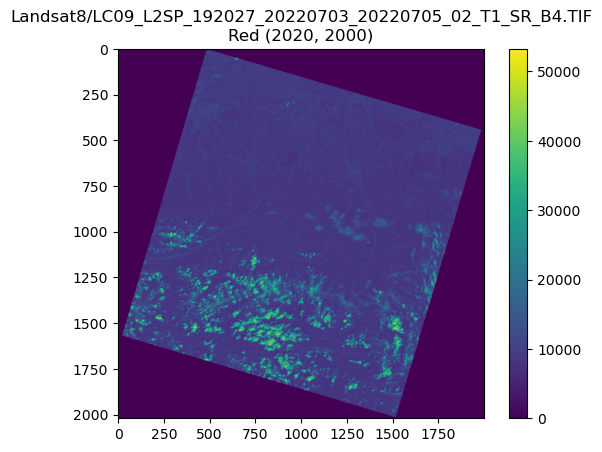

In [58]:
date = '2022-07-03'
redband = 'Landsat8/LC09_L2SP_192027_20220703_20220705_02_T1_SR_B4.TIF'.format(4)
nirband = 'Landsat8/LC09_L2SP_192027_20220703_20220705_02_T1_SR_B5.TIF'.format(5)

with rasterio.open(redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))

Text(0.5, 1.0, 'Landsat8/LC09_L2SP_192027_20220703_20220705_02_T1_SR_B5.TIF\nNIR (2020, 2000)')

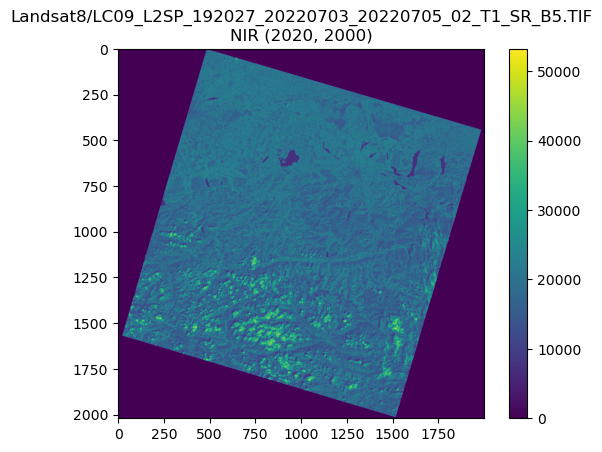

In [59]:
with rasterio.open(nirband) as src:
    oviews = src.overviews(1) 
    oview = oviews[1]
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))

C:\Users\leoni\AppData\Local\Temp\ipykernel_852\511382634.py:5: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


Text(0.5, 1.0, 'NDVI 2022-07-03')

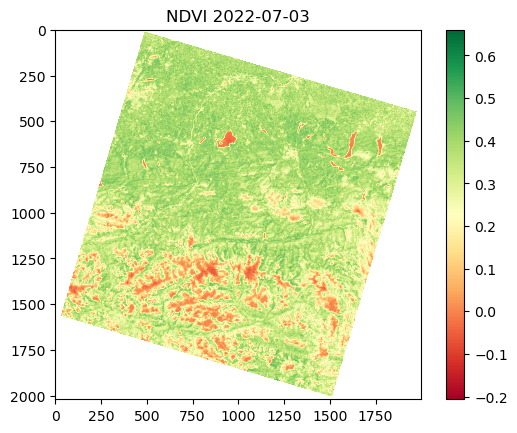

In [33]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))

In [36]:
localname = 'LC09_L2SP_192027_20220703_20220705_02_T1_NDVI_OVIEW.tif'

with rasterio.open(nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2000, 'height': 2020, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(120.0, 0.0, 196785.0,
       0.0, -120.0, 5378715.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0.5, 1.0, 'NDVI 2022-07-03')

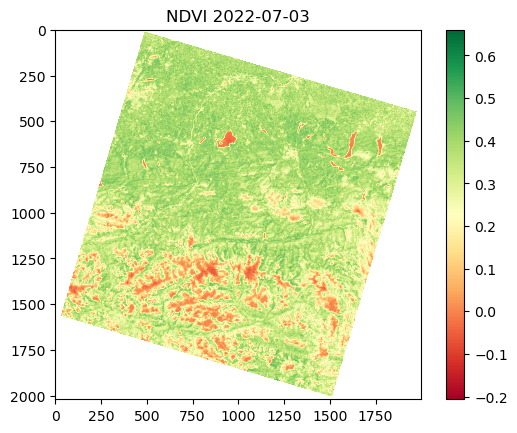

In [64]:
with rasterio.open(localname) as src:
    print(src.profile)
    ndvi = src.read(1) 

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))

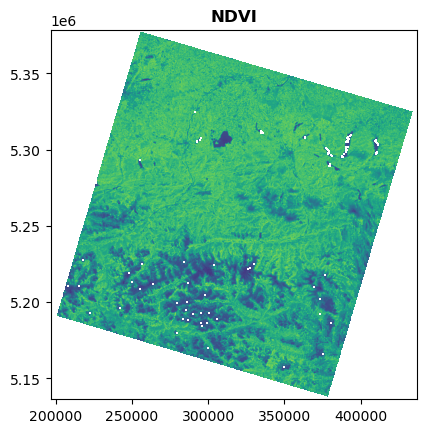

In [61]:
with rasterio.open(localname) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax, title='NDVI')

In [62]:
date2 = '2019-07-03'
redband2 = 'Landsat8/LC08_L2SP_192027_20190703_20200827_02_T1_SR_B{}.TIF'.format(4)
nirband2 = 'Landsat8/LC08_L2SP_192027_20190703_20200827_02_T1_SR_B{}.TIF'.format(5)

filepath = redband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1)
    oview = oviews[1]
    print('Decimation factor= {}'.format(oview))
    red2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

filepath = nirband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) 
    oview = oviews[1] 
    print('Decimation factor= {}'.format(oview))
    nir2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

ndvi2 = calc_ndvi(nir2, red2)

Opening: Landsat8/LC08_L2SP_192027_20190703_20200827_02_T1_SR_B4.TIF
Decimation factor= 4
Opening: Landsat8/LC08_L2SP_192027_20190703_20200827_02_T1_SR_B5.TIF
Decimation factor= 4


C:\Users\leoni\AppData\Local\Temp\ipykernel_852\511382634.py:5: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


Text(0.5, 1.0, 'NDVI 2019-07-03')

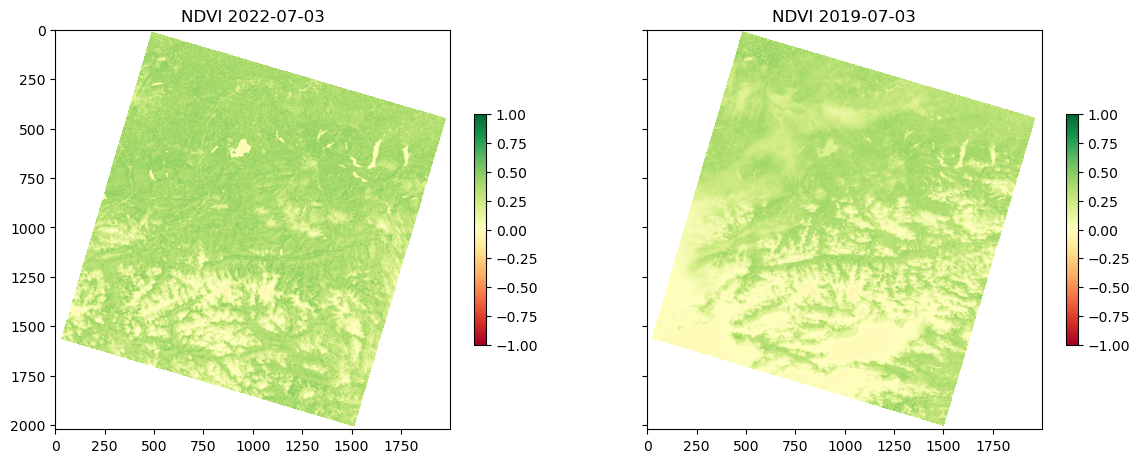

In [63]:
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=True)

plt.sca(axes[0])
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date))

plt.sca(axes[1])
plt.imshow(ndvi2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date2))